In [45]:
import pynq
import time
from pynq import PL
import xrfclk
import xrfdc
import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio
import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.daccomb as daccomb
import mkidgen3
import mkidgen3.util
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc
from mkidgen3.ifboard import IFBoard
import logging
from logging import getLogger
import json

In [46]:
def buf2complex(b, free=True):
    x = np.array(b).astype(np.uint16)
    x = x[..., 0] + 1j * x[..., 1]
    if free:
        b.freebuffer()
    return x

In [47]:
logging.basicConfig()
logging.getLogger('mkidgen3').setLevel('INFO')

In [48]:
ol = g3.configure('restest/restest.bit', clocks=True, external_10mhz=False, ignore_version=True)
print(f"PL Bitfile: {PL.bitfile_name}\nPL Timestamp: {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")

PL Bitfile: /home/xilinx/jupyter_notebooks/restest/restest.bit
PL Timestamp: 2022/3/11 19:24:8 +382598
Overlay timestamp: 2022/3/11 19:24:8 +382598  Loaded: True


## Setup DAC Table with a ramp

In [49]:
ramp=np.arange(2**19, dtype=np.complex64)
ramp.real%=(2**16)
ramp.imag=ramp.real

In [50]:
ol.dac_table_axim_0.stop()
ol.dac_table_axim_0.replay(ramp, tlast_every=256, fpgen=None)
ol.dac_table_axim_0.register_map

RegisterMap {
  CTRL = Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, RESERVED_3=0, RESERVED_4=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0),
  a_1 = Register(a=2022703104),
  a_2 = Register(a=0),
  length_r = Register(length_r=32767, RESERVED=0),
  tlast = Register(tlast=1, RESERVED=0),
  replay_length = Register(replay_length=255, RESERVED=0),
  run = Register(run=1, RESERVED=0)
}

## ADC Capture

In [53]:
ol.capture.axis2mm.cmd_ctrl_reg

{'r_busy': False,
 'r_err': False,
 'r_complete': True,
 'r_continuous': False,
 'r_increment_n': False,
 'r_tlast_syncd_n': True,
 'decode_error': False,
 'slave_error': False,
 'overflow_error': False,
 'aborting': False,
 'fifo_len': 8,
 'abort': 0}

In [114]:
ol.capture.axis2mm.clear_error()

In [58]:
adc=buf2complex(ol.capture.capture_adc(2**19))

## Plot ADC Out

In [116]:
N = adc_capture_data.size
Fs = 4.096e9 # ADC Sample Rate [Hz]
Tc = N/Fs # total collection time (seconds)
t = np.linspace(0,Tc,N) # Time vector (seconds)

Each of these segments crosses a 2048 sample mark, any rolling or misalignment in the capture should show up as a
 discontinuity.

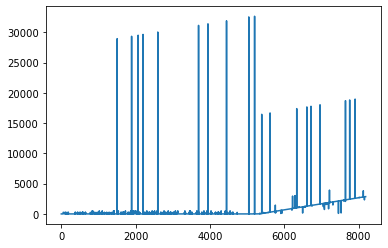

In [61]:
plt.plot(adc_capture_data.real.astype(np.uint16)[:8192])

#### Time Series

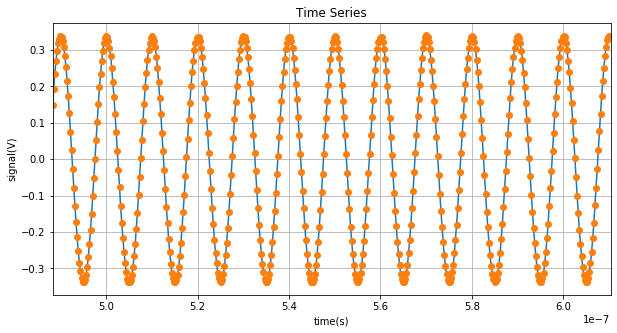

In [118]:
timeseries_plot_start=2000
timeseries_plot_stop= 2500
t_sl = slice(timeseries_plot_start,timeseries_plot_stop)

plt.figure(figsize=(10,5))
plt.plot(t[t_sl],adc_capture_data.real[t_sl])
plt.plot(t[t_sl],adc_capture_data.real[t_sl],"o")
plt.grid(True)
plt.xlabel("time(s)",position=(0.5,1))
plt.ylabel("signal(V)",position=(0,0.5))
plt.xlim(t[t_sl.start],t[t_sl.stop])
#plt.legend()
plt.title('Time Series');

### FFT

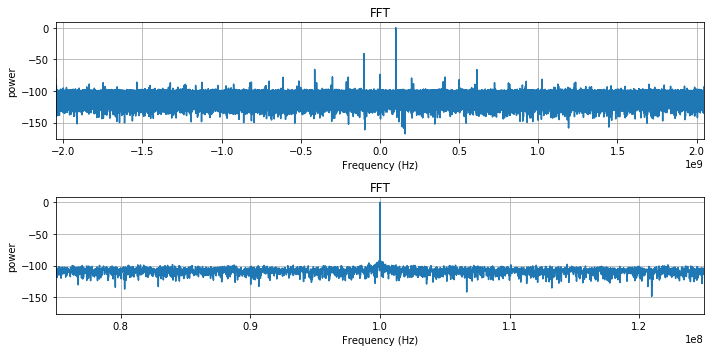

In [119]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plot_fft(adc_capture_data)
plt.subplot(212)
plot_fft(adc_capture_data, xlim=(75e6,125e6))
plt.tight_layout()

## Resonator selection

In [ ]:
g3.set_channels(tones)
ol.photon_pipe.reschan.bin_to_res.bins

#### Or manually

In [ ]:
bins = np.zeros(2048, dtype=int)
bins[:tones.size] = g3.drivers.bintores.opfb_bin_number(tones)
ol.photon_pipe.reschan.bin_to_res.bins=bins

## DDC Configuration

In [ ]:
g3.configure_ddc(tones)
ol.photon_pipe.reschan.resonator_ddc.tones

#### Or manually

In [33]:
ddctones = np.zeros((2, 2048))
ddctones[0, :tones.size] = g3.drivers.ddc.tone_increments(tones)
ddctones[1, :tones.size] = 0  # Phase offsets to 0
ol.photon_pipe.reschan.resonator_ddc.tones = ddctones

## OPFB Capture

### Check for rolling capture

Here we capture samples of every other OPFB bin 4 times in a row with a random sleep, then compute the average
magnitude in each bin and overplot. It may look like garbage, but it should look like _stable_ garbage.

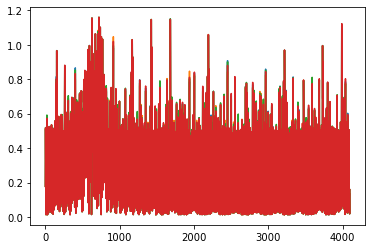

In [97]:
bins = np.arange(0,4096,2, dtype=int)
ol.photon_pipe.reschan.bin_to_res.bins=bins
x=[]
for i in range(4):
    time.sleep(np.random.uniform(0,1))
    x.append(buf2complex(ol.capture.capture_iq(500, groups='all', tap_location='rawiq')))
    plt.plot(bins,np.abs(x[-1]).mean(0))

### Now capture the full OPFB

In [98]:
def capture_opfb(n=256):
    out = np.zeros((n, 4096), dtype=np.complex64)
    ol.photon_pipe.reschan.bin_to_res.bins = range(0, 4096, 2)
    out[:, ::2] = buf2complex(ol.capture.capture_iq(n, 'all', tap_location='rawiq'))
    ol.photon_pipe.reschan.bin_to_res.bins = range(1, 4096, 2)
    out[:, 1::2] = buf2complex(ol.capture.capture_iq(n, 'all', tap_location='rawiq'))
    return out

In [120]:
spec=capture_opfb(512)

In [121]:
from skimage.feature import peak_local_max
peak_local_max(np.abs(spec).mean(0), min_distance=10, threshold_abs=.8,num_peaks=3)

array([[ 864],
       [ 896],
       [2704]])

to unravel the data

In [ ]:
ol.photon_pipe.reschan.bin_to_res.bins = range(0, 2048)
a=buf2complex(ol.capture.capture_iq(256, 'all', tap_location='rawiq')).ravel()
ol.photon_pipe.reschan.bin_to_res.bins = np.arange(0, 2048, dtype=int)+2048
b=buf2complex(ol.capture.capture_iq(256, 'all', tap_location='rawiq')).ravel()

The stream from the OPFB consists of beats of 16 bins, repeating every 256 beats. Bin to res syncs this on tlast and
selects 2048 of them for forwarding in beats of 8. Based on capture core tests these forwarded beats are placed in
RAM where we think.

If the stream to bin2res has a shift of n beats then the bin names are simply off by n.


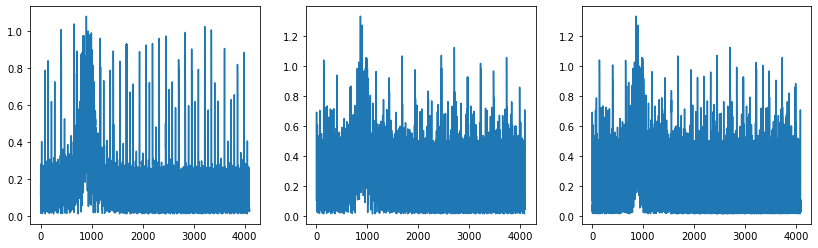

In [122]:
plt.figure(figsize=(14,4))
ps=np.abs(spec).mean(0)
plt.subplot(131)
plt.plot(np.arange(1,4096,2),ps[1::2])
plt.subplot(132)
plt.plot(np.arange(0,4096,2),ps[::2])
plt.subplot(133)
plt.plot(np.arange(4096),ps)

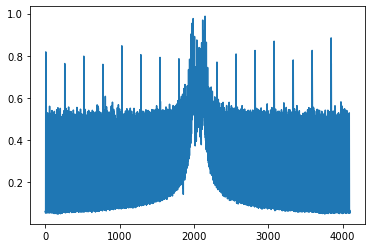

In [136]:
plt.plot(np.arange(4096),np.roll(np.abs(spec).mean(0),2148-3056))

In [144]:
spec.shape

(500, 4096)

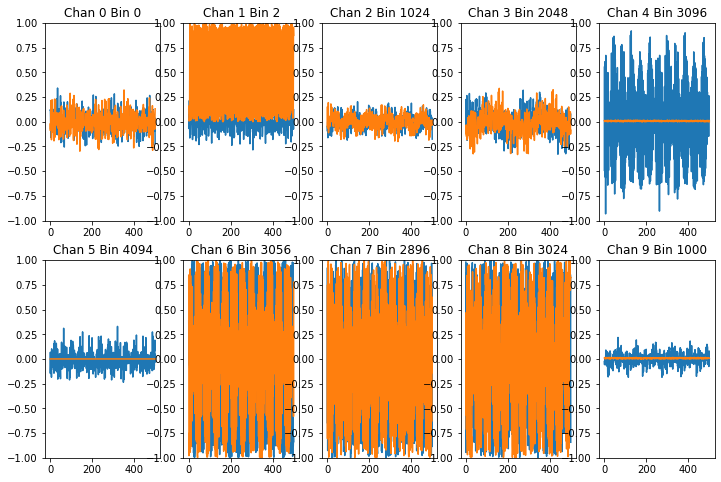

In [145]:
bins_to_plot=[0,2,1024,2048, 3096, 4094, 3056,2896,3024, 1000]
fig,axes=plt.subplots(2,5,figsize=(12,8))
for i,ax in zip(range(10),axes.flat):
    plt.sca(ax)
    plt.plot(spec[:,bins_to_plot[i]].real)
    plt.plot(spec[:,bins_to_plot[i]].imag)
    # plt.plot(x[:50,i].imag)
    plt.title(f'Chan {i} Bin {bins_to_plot[i]}')
    plt.ylim(-1,1)

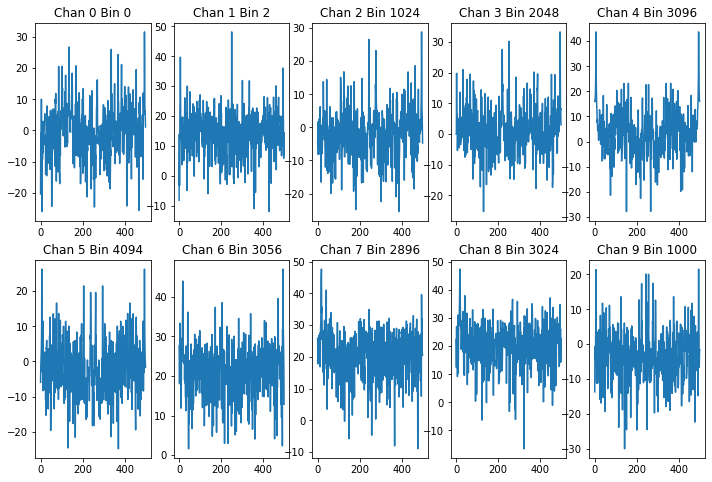

In [149]:
specfft = np.fft.fft(spec,axis=0)
specfft_db = 20 * np.log10(np.abs(specfft))
bins_to_plot=[0,2,1024,2048, 3096, 4094, 3056,2896,3024, 1000]
fig,axes=plt.subplots(2,5,figsize=(12,8))
for i,ax in zip(range(10),axes.flat):
    plt.sca(ax)
    plt.plot(np.fft.fftshift(specfft_db[:,bins_to_plot[i]]))
    plt.title(f'Chan {i} Bin {bins_to_plot[i]}')

In [ ]:
sio.savemat('300MHz_OPFB_out_test1.mat', mdict={'opfb_out_test_1':opfb_out})

In [ ]:
def gen_bin_cen(bin):
    return bin-2047

In [ ]:
gen_bin_cen(4095)

In [ ]:
bin_center = -2047

plt.plot(np.linspace(-2047-1,-2047+1,a_fft.shape[0]), np.fft.fftshift(20*np.log10(np.abs(a_fft[:,3000]))))
plt.plot(np.linspace(-2046-1,-2046+1,a_fft.shape[0]), np.fft.fftshift(20*np.log10(np.abs(a_fft[:,3001]))))


def plot_opfb_bins(data_in, bins, overlap=True):
    def gen_bin_freqs:
        return linspace()

In [ ]:
opfb_cap_result = ol.capture.capture_iq(8192, groups='all', tap_location='iq', duration=False) #rawiq=bin2res #iq=lowpassed  #ddciq=before lowpass (unsupported)

In [ ]:
opfb_cap_result.shape

In [ ]:
opfb_capture_data = opfb_cap_result[:,:,0]/2**15 + 1j*opfb_cap_result[:,:,1]/2**15

In [ ]:
opfb_cap_result.freebuffer()

In [ ]:
opfb_capture_data.shape

## Phase Capture

In [ ]:
phase = ol.capture.capture_phase(8192, groups='all', duration=False)

In [ ]:
phase.shape

In [ ]:
plt.plot(phase[:,0]/2**13)
plt.plot(phase[:,1]/2**13)
plt.plot(phase[:,2]/2**13)
plt.plot(phase[:,3]/2**13)

## Manual phase capture

In [ ]:
n=100
groups = [0,1,2,3,4]  #0-127
self=ol.capture

In [ ]:
self.switch.set_driver(slave=self.SOURCE_MAP['phase'], commit=True)

In [ ]:
print(self.axis2mm.cmd_ctrl_reg)
self.axis2mm.abort()
self.axis2mm.clear_error()
if not self.axis2mm.ready:
    print("capture core unable not ready, this shouldn't happen")
print(self.axis2mm.cmd_ctrl_reg)

In [ ]:
self.filter_phase.keep = groups
n_groups = self.filter_phase.n_kept

In [ ]:
# each group is 16 phases (32 bytes)
capture_bytes = n * 2 * n_groups*16

try:
    buffer = allocate((n, n_groups*16), dtype='i2', target=self.ddr4_0)
except RuntimeError:
    getLogger(__name__).warning(f'Insufficient space for requested samples.')
    raise RuntimeError('Insufficient free space')
addr = buffer.device_address

datavolume_mb = capture_bytes / 1024 ** 2
datarate_mbps = 32 * 512/4 * n_groups/128   #phases arrive 4@512 so the filter outputs every 4 clocks
captime = datavolume_mb / datarate_mbps

msg = (f"Capturing ~{datavolume_mb:.2f} MB of data @ {datarate_mbps:.1f} MBps. "
       f"ETA {datavolume_mb / datarate_mbps * 1000:.0f} ms")
print(msg)

In [ ]:
self.axis2mm.addr = buffer
self.axis2mm.len = n
self.axis2mm.start(continuous=False, increment=True)
self._capture('phase', capture_bytes, addr)
time.sleep(captime)

### Scratchpad